In [24]:
import numpy as np
from pretty_midi import PrettyMIDI

In [121]:
!pip install pydub fluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for fluidsynth: filename=fluidsynth-0.2-py3-none-any.whl size=4488 sha256=64007f43f2707c85ec5c32121cb68257f7e7c64be8b7e262b6e0cfeab7bf808d
  Stored in directory: /Users/adityaramachandra/Library/Caches/pip/wheels/47/19/60/453a1164e77de2979d36d2d670fbafc16d18757d66e20c7d35
Successfully built fluidsynth


In [124]:
import fluidsynth
from pydub import AudioSegment
import IPython.display as ipd

def midi_to_wav(midi_file, soundfont_file, output_wav='output.wav'):
    # Create FluidSynth synthesizer
    fs = fluidsynth.Synth()
    fs.start(driver="coreaudio")  # Use "coreaudio" for macOS, "alsa" for Linux, "dsound" for Windows

    # Load the SoundFont file
    sfid = fs.sfload(soundfont_file)
    fs.program_select(0, sfid, 0, 0)

    # Load the MIDI file
    fs.midi_file_select(midi_file)

    # Render the MIDI file to WAV
    wav_data = fs.get_samples()

    # Save WAV data to file
    wav_data = bytes(wav_data)
    with open(output_wav, 'wb') as wav_file:
        wav_file.write(wav_data)

    # Stop FluidSynth
    fs.delete()

    return output_wav

# Example MIDI file and SoundFont file paths (replace these with your own files)
midi_file_path = 'output_2.mid'
soundfont_file_path = 'abc.sf2'

# Convert MIDI to WAV
output_wav_path = midi_to_wav(midi_file_path, soundfont_file_path)

# Play the WAV file in the notebook
ipd.Audio(output_wav_path)

AttributeError: module 'fluidsynth' has no attribute 'Synth'

In [87]:
pT = piano_roll_ip.transpose(1, 0, 2)

In [114]:
def set_piano_roll_to_instrument(piano_roll, instrument, velocity=100, tempo=120.0, beat_resolution=16):
    # Calculate time per pixel
    tpp = 60.0 / tempo / float(beat_resolution)
    threshold = 60.0 / tempo / 4
    phrase_end_time = 60.0 / tempo * 4 * piano_roll.shape[0]
    # Create piano_roll_search that captures note onsets and offsets
    piano_roll = piano_roll.reshape((piano_roll.shape[0] * piano_roll.shape[1], piano_roll.shape[2]))
    piano_roll_diff = np.concatenate((np.zeros((1, 84), dtype=int), piano_roll, np.zeros((1, 84), dtype=int)))
    piano_roll_search = np.diff(piano_roll_diff.astype(int), axis=0)
    # Iterate through all possible(128) pitches

    for note_num in range(128):
        # Search for notes
        start_idx = (piano_roll_search[:, note_num] > 0).nonzero()
        start_time = list(tpp * (start_idx[0].astype(float)))
        # print('start_time:', start_time)
        # print(len(start_time))
        end_idx = (piano_roll_search[:, note_num] < 0).nonzero()
        end_time = list(tpp * (end_idx[0].astype(float)))
        # print('end_time:', end_time)
        # print(len(end_time))
        duration = [pair[1] - pair[0] for pair in zip(start_time, end_time)]
        # print('duration each note:', duration)
        # print(len(duration))

        temp_start_time = [i for i in start_time]
        temp_end_time = [i for i in end_time]

        for i in range(len(start_time)):
            # print(start_time)
            if start_time[i] in temp_start_time and i != len(start_time) - 1:
                # print('i and start_time:', i, start_time[i])
                t = []
                current_idx = temp_start_time.index(start_time[i])
                for j in range(current_idx + 1, len(temp_start_time)):
                    # print(j, temp_start_time[j])
                    if temp_start_time[j] < start_time[i] + threshold and temp_end_time[j] <= start_time[i] + threshold:
                        # print('popped start time:', temp_start_time[j])
                        t.append(j)
                        # print('popped temp_start_time:', t)
                for _ in t:
                    temp_start_time.pop(t[0])
                    temp_end_time.pop(t[0])
                # print('popped temp_start_time:', temp_start_time)

        start_time = temp_start_time
        # print('After checking, start_time:', start_time)
        # print(len(start_time))
        end_time = temp_end_time
        # print('After checking, end_time:', end_time)
        # print(len(end_time))
        duration = [pair[1] - pair[0] for pair in zip(start_time, end_time)]
        # print('After checking, duration each note:', duration)
        # print(len(duration))

        if len(end_time) < len(start_time):
            d = len(start_time) - len(end_time)
            start_time = start_time[:-d]
        # Iterate through all the searched notes
        for idx in range(len(start_time)):
            if duration[idx] >= threshold:
                # Create an Note object with corresponding note number, start time and end time
                note = pretty_midi.Note(velocity=velocity, pitch=note_num, start=start_time[idx], end=end_time[idx])
                # Add the note to the Instrument object
                instrument.notes.append(note)
            else:
                if start_time[idx] + threshold <= phrase_end_time:
                    # Create an Note object with corresponding note number, start time and end time
                    note = pretty_midi.Note(velocity=velocity, pitch=note_num, start=start_time[idx],
                                            end=start_time[idx] + threshold)
                else:
                    # Create an Note object with corresponding note number, start time and end time
                    note = pretty_midi.Note(velocity=velocity, pitch=note_num, start=start_time[idx],
                                            end=phrase_end_time)
                # Add the note to the Instrument object
                instrument.notes.append(note)
    # Sort the notes by their start time
    instrument.notes.sort(key=lambda note: note.start)
    # print(max([i.end for i in instrument.notes]))
    # print('tpp, threshold, phrases_end_time:', tpp, threshold, phrase_end_time)


def write_piano_roll_to_midi(piano_roll, filename, program_num=0, is_drum=False, velocity=100,
                             tempo=120.0, beat_resolution=16):
    # Create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
    # Create an Instrument object
    instrument = pretty_midi.Instrument(program=program_num, is_drum=is_drum)
    # Set the piano roll to the Instrument object
    set_piano_roll_to_instrument(piano_roll, instrument, velocity, tempo, beat_resolution)
    # Add the instrument to the PrettyMIDI object
    midi.instruments.append(instrument)
    # Write out the MIDI data
    midi.write(filename)


def write_piano_rolls_to_midi(piano_rolls, program_nums=None, is_drum=None, filename='test.mid', velocity=100,
                              tempo=120.0, beat_resolution=24):
    if len(piano_rolls) != len(program_nums) or len(piano_rolls) != len(is_drum):
        print("Error: piano_rolls and program_nums have different sizes...")
        return False
    if not program_nums:
        program_nums = [0, 0, 0]
    if not is_drum:
        is_drum = [False, False, False]
    # Create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
    # Iterate through all the input instruments
    for idx in range(len(piano_rolls)):
        # Create an Instrument object
        instrument = pretty_midi.Instrument(program=program_nums[idx], is_drum=is_drum[idx])
        # Set the piano roll to the Instrument object
        set_piano_roll_to_instrument(piano_rolls[idx], instrument, velocity, tempo, beat_resolution)
        # Add the instrument to the PrettyMIDI object
        midi.instruments.append(instrument)
    # Write out the MIDI data
    midi.write(filename)

In [116]:
write_piano_roll_to_midi(piano_roll_ip, "output.mid")


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 84 and the array at index 1 has size 1

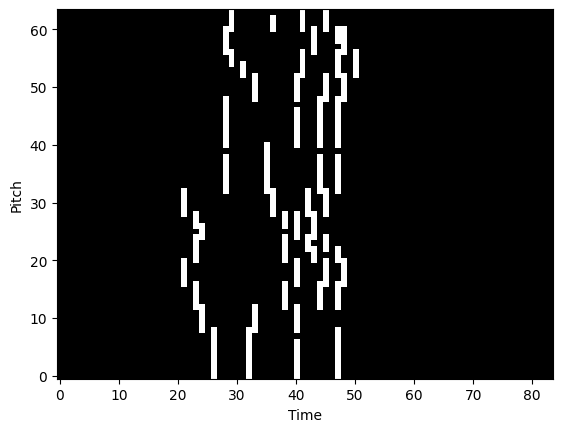

In [18]:
import matplotlib.pyplot as plt

plt.imshow(piano_roll, aspect='auto', cmap='gray', origin='lower')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.show()

In [21]:
pT = piano_roll.transpose(1, 0, 2)

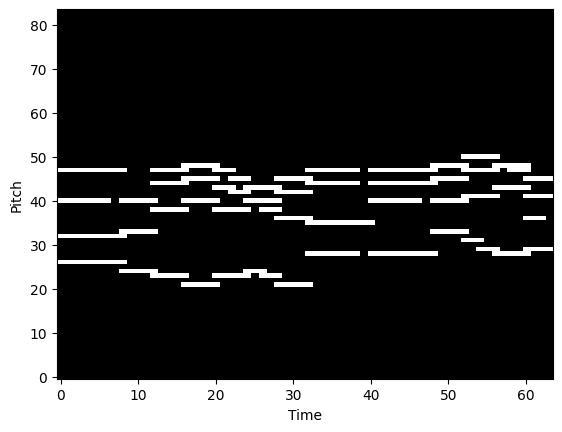

In [22]:
plt.imshow(pT, aspect='auto', cmap='gray', origin='lower')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.show()

In [112]:
np.concatenate((np.zeros((1, 84), dtype=int), piano_roll_ip_r, np.zeros((1, 84), dtype=int)))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [146]:
from midiutil import MIDIFile

def piano_roll_to_midi(piano_roll, tempo=120, output_file='output.mid'):
    # Get the number of notes and time steps
    num_notes, num_steps = len(piano_roll[0]), len(piano_roll)

    # Create a MIDIFile object with one track
    midi = MIDIFile(1)

    # Set the tempo
    midi.addTempo(0, 0, tempo)

    # Define the instrument (use 0 for piano)
    midi.addProgramChange(0, 0, 0, 0)

    # Convert piano roll to MIDI events
    for time in range(num_steps):
        for pitch in range(num_notes):
            if piano_roll[time][pitch] != 0:
                midi.addNote(0, 0, pitch + 21, time, 1, 100)  # channel=0, duration=1, volume=100

    # Write the MIDI file
    with open(output_file, 'wb') as midi_file:
        midi.writeFile(midi_file)


# Convert piano roll to MIDI and save the MIDI file
piano_roll_ip = np.load('dataset/CP_C/train/classic_piano_train_45.npy')
piano_roll_ip_r = piano_roll_ip.reshape(64, 84)
piano_roll_to_midi(piano_roll_ip_r, tempo=120, output_file='output_CP_C.mid')

piano_roll_ip = np.load('dataset/CP_P/train/pop_piano_train_45.npy')
piano_roll_ip_r = piano_roll_ip.reshape(64, 84)
piano_roll_to_midi(piano_roll_ip_r, tempo=120, output_file='output_CP_P.mid')

piano_roll_ip = np.load('dataset/JC_C/train/classic_piano_train_45.npy')
piano_roll_ip_r = piano_roll_ip.reshape(64, 84)
piano_roll_to_midi(piano_roll_ip_r, tempo=120, output_file='output_JC_C.mid')

piano_roll_ip = np.load('dataset/JC_J/train/jazz_piano_train_45.npy')
piano_roll_ip_r = piano_roll_ip.reshape(64, 84)
piano_roll_to_midi(piano_roll_ip_r, tempo=120, output_file='output_JC_J.mid')

piano_roll_ip = np.load('dataset/JCP_mixed/classic_piano_train_45.npy')
piano_roll_ip_r = piano_roll_ip.reshape(64, 84)
piano_roll_to_midi(piano_roll_ip_r, tempo=120, output_file='output_JCP_mixed.mid')

piano_roll_ip = np.load('dataset/JP_J/train/jazz_piano_train_45.npy')
piano_roll_ip_r = piano_roll_ip.reshape(64, 84)
piano_roll_to_midi(piano_roll_ip_r, tempo=120, output_file='output_JP_J.mid')

piano_roll_ip = np.load('dataset/JP_P/train/pop_piano_train_8.npy')
piano_roll_ip_r = piano_roll_ip.reshape(64, 84)
piano_roll_to_midi(piano_roll_ip_r, tempo=120, output_file='output_JP_P.mid')

In [138]:
# from midiutil import MIDIFile

# def piano_roll_to_midi(piano_roll, tempo=120, output_file='output.mid'):
#     # Get the number of notes and time steps
#     num_notes, num_steps = len(piano_roll[0]), len(piano_roll)

#     # Create a MIDIFile object with one track
#     midi = MIDIFile(1)

#     # Set the tempo
#     midi.addTempo(0, 0, tempo)

#     # Define the instrument (use 0 for piano)
#     midi.addProgramChange(0, 0, 0, 0)

#     # Convert piano roll to MIDI events
#     for time in range(num_steps):
#         for pitch in range(num_notes):
#             if piano_roll[time][pitch] != 0:
#                 midi.addNote(0, 0, pitch + 21, time, 1, 100)  # channel=0, duration=1, volume=100

#     # Write the MIDI file
#     with open(output_file, 'wb') as midi_file:
#         midi.writeFile(midi_file)


# # Convert piano roll to MIDI and save the MIDI file
# piano_roll_ip = np.load('dataset/CP_C/train/classic_piano_train_75.npy')
# piano_roll_ip_r = piano_roll_ip.reshape(64, 84)
# piano_roll_to_midi(piano_roll_ip_r, tempo=120, output_file='output.mid')

In [147]:
from music21 import midi

mf = midi.MidiFile()
mf.open('output_CP_C.mid') # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

In [148]:
mf = midi.MidiFile()
mf.open('output_CP_P.mid') # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

In [149]:
mf = midi.MidiFile()
mf.open('output_JC_C.mid') # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

In [150]:
mf = midi.MidiFile()
mf.open('output_JC_J.mid') # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

In [143]:
mf = midi.MidiFile()
mf.open('output_JCP_mixed.mid') # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

In [144]:
mf = midi.MidiFile()
mf.open('output_JP_J.mid') # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

In [145]:
mf = midi.MidiFile()
mf.open('output_JP_P.mid') # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

In [151]:
piano_roll_ip_1 = np.load('dataset/CP_C/train/classic_piano_train_45.npy')
piano_roll_ip_2 = np.load('dataset/JC_C/train/classic_piano_train_45.npy')

In [152]:
piano_roll_ip_1.shape, piano_roll_ip_2.shape

((64, 84, 1), (64, 84, 1))

In [154]:
np.subtract(piano_roll_ip_1, piano_roll_ip_2)

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.